# Задача

Сформировать сетку полигонов вокруг точек из таблицы `facility`

## Подключаем библиотеки

* Единоразово устанавливаем h3pandas

In [1]:
# %pip install h3pandas

In [2]:
import h3pandas
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

## Определяем функцию для вывода данных

* Функция вывода центрального региона набора геоданных

In [3]:
def get_center(df, qt = 0.1):
    return df.loc[
        (df['lng'] > df['lng'].quantile(qt)) &
        (df['lng'] < df['lng'].quantile(1-qt)) &
        (df['lat'] > df['lat'].quantile(qt)) &
        (df['lat'] < df['lat'].quantile(1-qt))]

## Грузим данные

In [4]:
facility = pd.read_csv('data/facility.csv')

In [5]:
facility.head(3)

,object_id,type2,name,coordinats,address,category,x,y,geometry
0,13,Обьекты бизнеса,Santa Pasta,"[64.5332, 40.526401]","Троицкий проспект, 21",Кафе,64.533200,40.526401,010100000075CAA31B614344408A8EE4F21F225040
1,40,Обьекты бизнеса,Римская кофейня,"[64.545284, 40.550311]","Воскресенская, 102",Кафе,64.545284,40.550311,010100000085D04197704644400DC2DCEEE5225040
2,173,Обьекты социальной инфраструктуры,Коммунар,"[64.533747, 40.514836]",Без адреса,Музеи,64.533747,40.514836,0101000000D8666325E6414440A4552DE928225040


## Обрабатываем данные

* Проверяем что нет нулей в object_id
* Привеодим object_id к целочисленному значению
* Переименовываем столбцы для h3pandas
* Удаляем лишние столбцы

In [6]:
nulls = len(facility[facility['object_id'].isnull()])
assert nulls == 0

In [7]:
facility = facility.astype({'object_id': 'int32'})
facility.head(3)

,object_id,type2,name,coordinats,address,category,x,y,geometry
0,13,Обьекты бизнеса,Santa Pasta,"[64.5332, 40.526401]","Троицкий проспект, 21",Кафе,64.533200,40.526401,010100000075CAA31B614344408A8EE4F21F225040
1,40,Обьекты бизнеса,Римская кофейня,"[64.545284, 40.550311]","Воскресенская, 102",Кафе,64.545284,40.550311,010100000085D04197704644400DC2DCEEE5225040
2,173,Обьекты социальной инфраструктуры,Коммунар,"[64.533747, 40.514836]",Без адреса,Музеи,64.533747,40.514836,0101000000D8666325E6414440A4552DE928225040


In [8]:
facility = facility.rename({'y': 'lng', 'x': 'lat'}, axis=1)
facility.head(3)

,object_id,type2,name,coordinats,address,category,lat,lng,geometry
0,13,Обьекты бизнеса,Santa Pasta,"[64.5332, 40.526401]","Троицкий проспект, 21",Кафе,64.533200,40.526401,010100000075CAA31B614344408A8EE4F21F225040
1,40,Обьекты бизнеса,Римская кофейня,"[64.545284, 40.550311]","Воскресенская, 102",Кафе,64.545284,40.550311,010100000085D04197704644400DC2DCEEE5225040
2,173,Обьекты социальной инфраструктуры,Коммунар,"[64.533747, 40.514836]",Без адреса,Музеи,64.533747,40.514836,0101000000D8666325E6414440A4552DE928225040


In [9]:
facility = facility.drop(columns=['coordinats', 'geometry'])
facility.head(3)

,object_id,type2,name,address,category,lat,lng
0,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,64.533200,40.526401
1,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,64.545284,40.550311
2,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,64.533747,40.514836


## Проверяем, что у нас в центер города

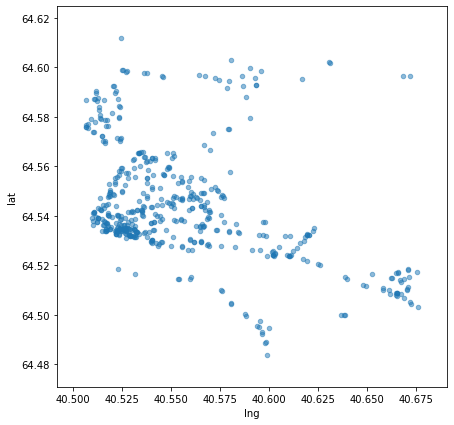

In [10]:
get_center(facility, 0.08).plot.scatter(x='lng', y='lat', figsize=(7,7), alpha=0.5)

## Приводим данные к формату h3pandas

In [11]:
facility3 = facility.h3.geo_to_h3(9)
facility3.head()

,object_id,type2,name,address,category,lat,lng
h3_09,,,,,,,
891150a881bffff,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,64.533200,40.526401
891150a8827ffff,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,64.545284,40.550311
891150a88d7ffff,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,64.533747,40.514836
891150a895bffff,379,Парк,NaN,Парк Зарусье,NaN,64.542998,40.560676
89115032437ffff,354,Парк,NaN,Майский,NaN,64.523584,40.610349


In [12]:
geofacility3 = facility3.h3.h3_to_geo_boundary()
geofacility3.head(3)

,object_id,type2,name,address,category,lat,lng,geometry
h3_09,,,,,,,,
891150a881bffff,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,64.533200,40.526401,"POLYGON ((40.52461 64.53358, 40.52763 64.53259..."
891150a8827ffff,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,64.545284,40.550311,"POLYGON ((40.54855 64.54338, 40.55157 64.54239..."
891150a88d7ffff,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,64.533747,40.514836,"POLYGON ((40.51124 64.53404, 40.51426 64.53305..."


## Рисуем наши полигоны в центер города

In [13]:
# Раскомментировать в случае надобности
#geofacility3.explore(width='30%', height='60%')

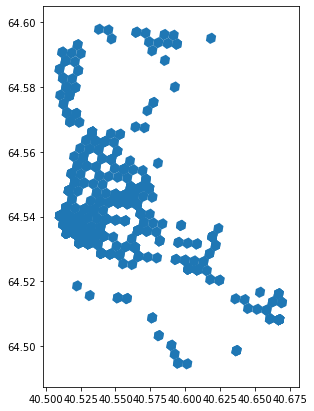

In [14]:
get_center(geofacility3).plot(figsize=(7,7))

## Строим набор данных для точек

In [15]:
facility.head(3)

,object_id,type2,name,address,category,lat,lng
0,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,64.533200,40.526401
1,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,64.545284,40.550311
2,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,64.533747,40.514836


In [16]:
geometry = [Point(xy) for xy in zip(facility.lng, facility.lat)]
geofacility = gpd.GeoDataFrame(facility, crs=geofacility3.crs, geometry=geometry)
geofacility.head(3)

,object_id,type2,name,address,category,lat,lng,geometry
0,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,64.533200,40.526401,POINT (40.52640 64.53320)
1,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,64.545284,40.550311,POINT (40.55031 64.54528)
2,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,64.533747,40.514836,POINT (40.51484 64.53375)


## Отображаем точки и полигоны

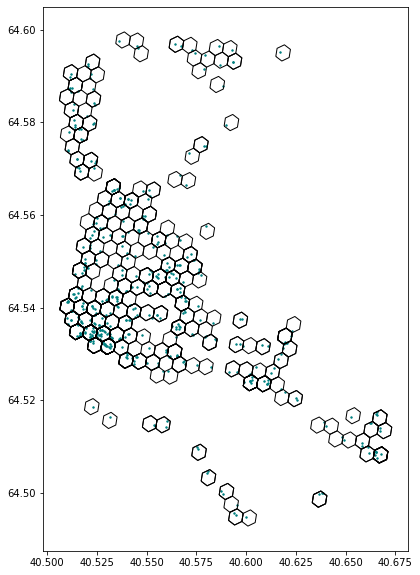

In [17]:
ax = get_center(geofacility).plot(
    figsize=(10,10), facecolor="teal", markersize=2)
get_center(geofacility3).plot(
    ax=ax, figsize=(10,10), facecolor="none", edgecolor="black")

## Готовим набор к экспорту

In [18]:
geofacility3.head(3)

,object_id,type2,name,address,category,lat,lng,geometry
h3_09,,,,,,,,
891150a881bffff,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,64.533200,40.526401,"POLYGON ((40.52461 64.53358, 40.52763 64.53259..."
891150a8827ffff,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,64.545284,40.550311,"POLYGON ((40.54855 64.54338, 40.55157 64.54239..."
891150a88d7ffff,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,64.533747,40.514836,"POLYGON ((40.51124 64.53404, 40.51426 64.53305..."


In [19]:
geometry = geofacility3['geometry']
data = geofacility3['object_id']
gdf = gpd.GeoDataFrame(data=data, geometry=geometry, crs=geofacility3.crs)
gdf = gdf.reset_index()
gdf = gdf.drop(columns=['h3_09'])
gdf.head(3)

,object_id,geometry
0,13,"POLYGON ((40.52461 64.53358, 40.52763 64.53259..."
1,40,"POLYGON ((40.54855 64.54338, 40.55157 64.54239..."
2,173,"POLYGON ((40.51124 64.53404, 40.51426 64.53305..."


## Экспортируем набор данных с полигонами

In [20]:
gdf.to_file('data/facility.geojson', driver='GeoJSON')

## Экспортируем данные для DataLens

In [22]:
all_res = []

def convert(df):
    for _, row in df.iterrows():
        polygon = row.geometry
        x, y = polygon.exterior.xy
        pairs = zip(x, y)
        coords = []
        for pair in pairs:
            coords.append([pair[1], pair[0]])
        obj = {}
        obj['object_id'] = row.object_id
        obj['geometry'] = [coords]
        all_res.append(obj)

convert(gdf)

gdf_df = pd.DataFrame(all_res)
gdf_df.head(3)

,object_id,geometry
0,13,"[[[64.53357960675277, 40.52460840474879], [64...."
1,40,"[[[64.5433789533762, 40.54854571749962], [64.5..."
2,173,"[[[64.53404159037963, 40.511240128323244], [64..."


In [35]:
gdf_df.to_csv('data/facility_polygons_lens.csv', index=False)

In [27]:
facility.head(3)

,object_id,type2,name,address,category,lat,lng
0,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,64.533200,40.526401
1,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,64.545284,40.550311
2,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,64.533747,40.514836


In [32]:
geometry = [[xy[1], xy[0]] for xy in zip(facility.lng, facility.lat)]

In [33]:
facility_dl = pd.DataFrame(facility[['object_id', 'type2', 'name', 'address', 'category']])
facility_dl['geometry'] = geometry
facility_dl.head(3)

,object_id,type2,name,address,category,geometry
0,13,Обьекты бизнеса,Santa Pasta,"Троицкий проспект, 21",Кафе,"[40.526401, 64.5332]"
1,40,Обьекты бизнеса,Римская кофейня,"Воскресенская, 102",Кафе,"[40.550311, 64.545284]"
2,173,Обьекты социальной инфраструктуры,Коммунар,Без адреса,Музеи,"[40.514836, 64.533747]"


In [37]:
facility_dl.to_csv('data/facility_lens.csv', quotechar='$', index=False)